In [12]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from group_sae.utils import cmap

## MAAD

In [3]:
p160_eval = pd.read_csv("eval/pythia_160m_jumprelu_cluster.csv")
p160_maad = pd.read_json("../groups/maad/pythia_160m.json").T

g2_eval = pd.read_csv("eval/gemma2_2b_jumprelu_cluster.csv")
g2_maad = pd.read_json("../groups/maad/gemma2_2b.json").T

In [4]:
p160_eval = p160_eval.join(p160_maad["maad"], on="G")
g2_eval = g2_eval.join(g2_maad["maad"], on="G")

In [5]:
p160_plot = p160_eval.groupby("G").mean()
g2_plot = g2_eval.groupby("G").mean()

<Axes: xlabel='maad', ylabel='explained_variance'>

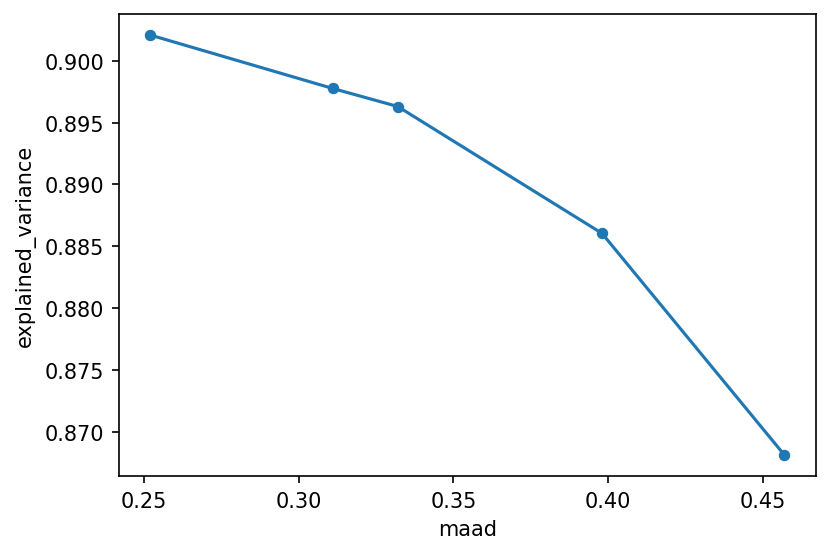

In [18]:
fig = plt.figure(figsize=(6, 4), dpi=150)

sns.lineplot(p160_plot, x="maad", y="explained_variance")
sns.scatterplot(p160_plot, x="maad", y="explained_variance")